<a href="https://colab.research.google.com/github/pedrozamboni/bank_cds/blob/main/xgboost_predict_cds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df = pd.read_excel("/content/drive/MyDrive/cabra/I am sharing 'Data_Table' with you").dropna().reset_index(drop=True)
df['ts'] = pd.to_datetime(df.Time, format = "%d.%m.%Y")

In [3]:
X = np.array(df.drop(["ts","Time","Banks CDS_avg"], axis = 1))
y = np.array(df['Banks CDS_avg'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  shuffle=True,random_state=785)

In [5]:
xgb_reg1 = xgboost.XGBRegressor(max_depth=100,
                                   n_estimators=1500,
                                   learning_rate=.01)

## fit it
xgb_reg1.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[17:39:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:195.073
[1]	validation_0-rmse:193.145
[2]	validation_0-rmse:191.24
[3]	validation_0-rmse:189.355
[4]	validation_0-rmse:187.482
[5]	validation_0-rmse:185.635
[6]	validation_0-rmse:183.8
[7]	validation_0-rmse:181.991
[8]	validation_0-rmse:180.196
[9]	validation_0-rmse:178.425
[10]	validation_0-rmse:176.666
[11]	validation_0-rmse:174.927
[12]	validation_0-rmse:173.203
[13]	validation_0-rmse:171.498
[14]	validation_0-rmse:169.809
[15]	validation_0-rmse:168.144
[16]	validation_0-rmse:166.487
[17]	validation_0-rmse:164.853
[18]	validation_0-rmse:163.233
[19]	validation_0-rmse:161.629
[20]	validation_0-rmse:160.033
[21]	validation_0-rmse:158.46
[22]	validation_0-rmse:156.903
[23]	validation_0-rmse:155.356
[24]	validation_0-rmse:153.827
[25]	validation_0-rmse:152.315
[26]	validation_0-rmse:150.819
[27]	validation_0-rmse:149.331
[28]	validation_0-r

XGBRegressor(learning_rate=0.01, max_depth=100, n_estimators=1500)

In [7]:
print("RMSE:", mean_squared_error(y_test,xgb_reg1.predict(X_test),squared=False))
print("MSE:" ,mean_squared_error(y_test,xgb_reg1.predict(X_test),squared=True))
print("R2_score:", r2_score(y_test,xgb_reg1.predict(X_test)))
print("mae:", mean_absolute_error(y_test,xgb_reg1.predict(X_test)))
print("mape:", mean_absolute_percentage_error(y_test,xgb_reg1.predict(X_test)))

RMSE: 3.940801574345869
MSE: 15.529917048366881
R2_score: 0.9984642345411159
mae: 2.336362089128886
mape: 0.013990519023589476


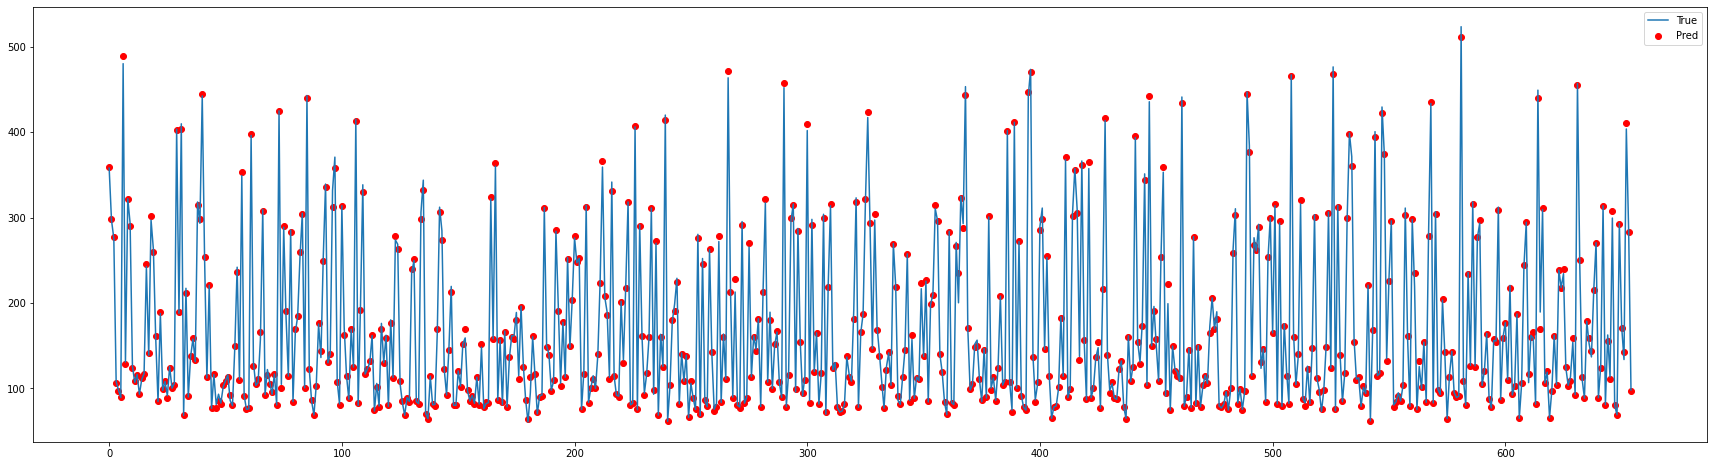

In [8]:
plt.figure(figsize=(30,8))
plt.plot(range(0,len(X_test)),y_test,label = "True")
plt.scatter(range(0,len(X_test)),xgb_reg1.predict(X_test),c='r',label= 'Pred')
plt.legend()

In [9]:
feature_important = xgb_reg1.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

In [10]:
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

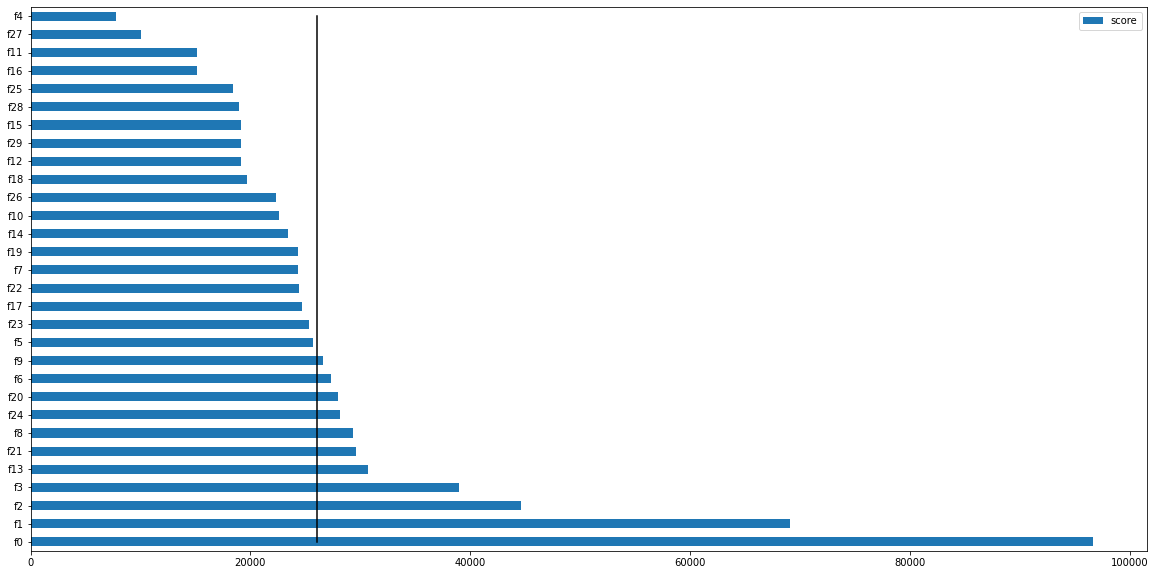

In [12]:
data.plot(kind='barh', figsize = (20,10))
plt.plot(np.full((30), 26089.838710),data.index, 'k')

In [17]:
list( df.drop(["ts","Time","Banks CDS_avg"], axis = 1).columns.to_list()[i] for i in [0,1,2,3,13,21,8,24,20,6] )

['REPUBLIC.OF.AUSTRIA.SNR.CR.5Y.E...CDS.PREM..MID',
 'KINGDOM.OF.SPAIN.SNR.CR.5Y.E...CDS.PREM..MID',
 'KINGDOM.OF.BELGIUM.SNR.CR.5Y.E...CDS.PREM..MID',
 'IRELAND.SNR.CR.5Y.E...CDS.PREM..MID',
 'ATHEX.COMPOSITE...PRICE.INDEX',
 'DS.ITRAXX.EUROPE.5Y..EOD.CONT.SERIES...CDS.PREM..MID',
 'EURO.STOXX.50 PRICE.INDEX',
 'Termspread_Griechenland',
 'VDAX-NEW VOLATILITY INDEX - PRICE INDEX',
 'FEDERAL.REP.GERMANY.SNR.CR.5Y.E...CDS.PREM..MID']

Using cv

In [18]:
kfold = KFold(n_splits=5, 
                 shuffle = True,
                 random_state=614)
kfold.split(X_train, y_train)

<generator object _BaseKFold.split at 0x7fe7a8bf9270>

In [ ]:
preds = {}
n = 0
for train_index, test_index in kfold.split(X_train, y_train):
    ## get the kfold training data
    X_train_train = X_train[train_index,:]
    y_train_train = y_train[train_index]
    
    ## get the holdout data
    X_holdout = X_train[test_index,:]
    y_holdout = y_train[test_index]
    
    model = xgboost.XGBRegressor(max_depth=100,
                                   n_estimators=1500,
                                   learning_rate=.01)

    ## fit it
    model.fit(X_train_train, y_train_train, eval_set=[(X_holdout, y_holdout)])
    preds[n] = model.predict(X_test)
    n += 1

In [20]:
zeros  = np.zeros(655,)
for i in preds.keys():
    zeros = np.add(zeros,preds[i])

average_preds = zeros/len(preds.keys())

In [21]:
for i in preds.keys():
    print(i)
    print("RMSE:", mean_squared_error(y_test,preds[i],squared=False))
    print("MSE:" ,mean_squared_error(y_test,preds[i],squared=True))
    print("R2_score:", r2_score(y_test,preds[i]))
print("Average")
print("RMSE:", mean_squared_error(y_test,average_preds,squared=False))
print("MSE:" ,mean_squared_error(y_test,average_preds,squared=True))
print("R2_score:", r2_score(y_test,average_preds))

0
RMSE: 4.457472358382689
MSE: 19.86905982574573
R2_score: 0.9980351333696215
1
RMSE: 4.284203746182228
MSE: 18.354401738801837
R2_score: 0.9981849190745098
2
RMSE: 4.77241600854301
MSE: 22.775954558597594
R2_score: 0.9977476683104443
3
RMSE: 4.523519095375456
MSE: 20.46222500622639
R2_score: 0.9979764748080362
4
RMSE: 4.283839587110265
MSE: 18.351281608093046
R2_score: 0.998185227626639
Average
RMSE: 4.034228428741259
MSE: 16.27499901526417
R2_score: 0.9983905528115075


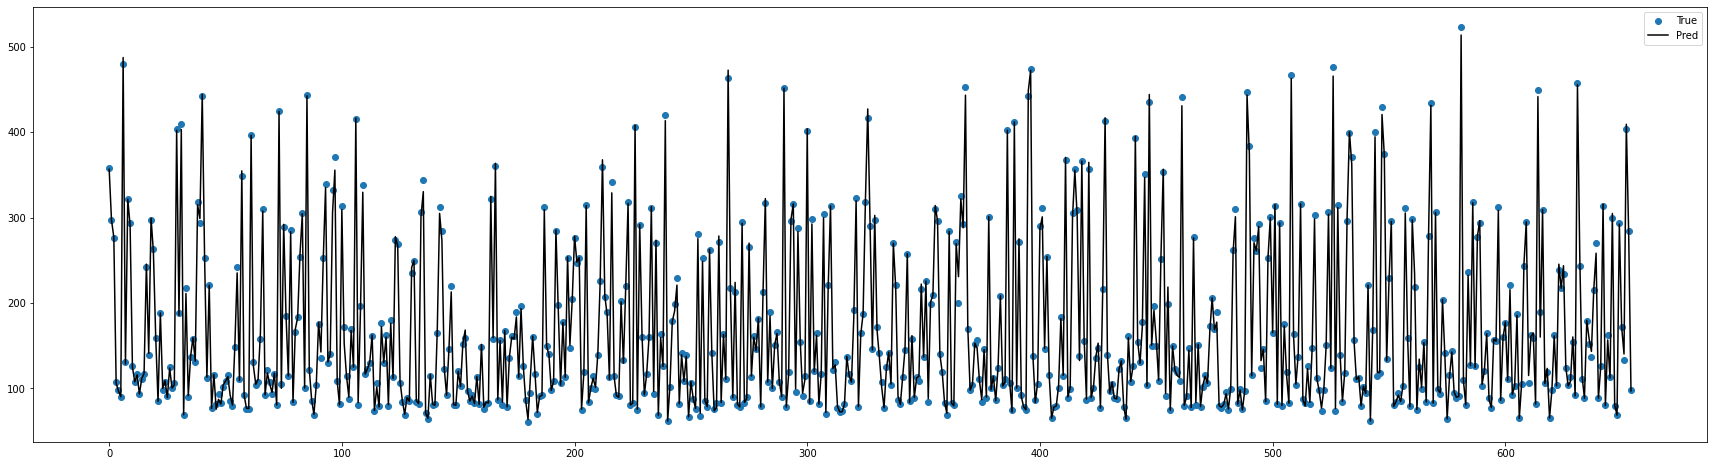

In [22]:
plt.figure(figsize=(30,8))
plt.scatter(range(0,len(X_test)),y_test,label = "True")
plt.plot(range(0,len(X_test)),average_preds,'k',label= 'Pred')
plt.legend()